In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import matplotlib.colors

categorized_restaurants_path = 'Categorized_restaurants.xlsx'
nutrition_path = 'Eating_out_nutrition.xlsx'
# Read Excel to df_place DataFrame
file_path = 'tokyo_unique_found_places.xlsx'
df_place = pd.read_excel(file_path)

df_restaurants = pd.read_excel(categorized_restaurants_path)
df_nutrition = pd.read_excel(nutrition_path, sheet_name='nutrition')
df_carbon = pd.read_excel(nutrition_path, sheet_name='carbon')

df_restaurants['FIES_category'] = df_restaurants['FIES_category'].astype(str)
df_nutrition['Type'] = df_nutrition['Type'].astype(str)

# FIES_category and Type （left join）
df_restaurants = pd.merge(df_restaurants, df_nutrition, left_on='FIES_category', right_on='Type', how='left')

# Merge df_place 'priceLevel', 'rating', 'userRatingCount', 'currentOpeningHours'
df_restaurants = pd.merge(df_restaurants, df_place[['id', 'priceLevel', 'rating', 'userRatingCount', 'currentOpeningHours']], on='id', how='left')
merged_data.to_excel('merged_data_with_place_info.xlsx', index=False)
df_restaurants.to_excel('restaurant_price.xlsx', index=False)


In [3]:
# add columes to df_nutrition
df_nutrition['Protein(g)/100kcal'] = (df_nutrition['Protein(g)'] / df_nutrition['Energy(kcal)']) * 100
df_nutrition['Lipid(g)/100kcal'] = (df_nutrition['Lipid(g)'] / df_nutrition['Energy(kcal)']) * 100
df_nutrition['Carbohydrates(g)/100kcal'] = (df_nutrition['Carbohydrates(g)'] / df_nutrition['Energy(kcal)']) * 100
df_nutrition['Salt equivalent(g)/100kcal'] = (df_nutrition['Salt equivalent(g)'] / df_nutrition['Energy(kcal)']) * 100

df_nutrition['NDS-Protein'] = (df_nutrition['Protein(g)'] / df_nutrition['Energy(kcal)']) * 100 /2.514728797
df_nutrition['NDS-Lipid'] = (df_nutrition['Lipid(g)'] / df_nutrition['Energy(kcal)']) * 100 / 2.777496058
df_nutrition['NDS-Carbohydrates'] = (df_nutrition['Carbohydrates(g)'] / df_nutrition['Energy(kcal)']) * 100 / 14.37502881
df_nutrition['NDS-Salt equivalent'] = (df_nutrition['Salt equivalent(g)'] / df_nutrition['Energy(kcal)']) * 100 / 0.311353851

# NDS 
df_nutrition['NDS'] = (df_nutrition['NDS-Protein'] + df_nutrition['NDS-Carbohydrates'] - df_nutrition['NDS-Lipid'] - df_nutrition['NDS-Salt equivalent']) / 4

# normalize NDS
NDS_min = df_nutrition['NDS'].min()
NDS_max = df_nutrition['NDS'].max()

df_nutrition['NDS_normalized'] = (df_nutrition['NDS'] - NDS_min) / (NDS_max - NDS_min)

df_merged = df_restaurants.merge(df_nutrition, left_on='FIES_category', right_on='Type', how='left')
df_merged.to_excel('df_merged.xlsx', index=False)


In [4]:
file_path = 'Restaurant_500m_district.csv'
df = pd.read_csv(file_path)
# df_place'priceLevel', 'rating', 'userRatingCount', 'currentOpeningHours'
df = pd.merge(df, df_place[['id', 'priceLevel', 'rating', 'userRatingCount', 'currentOpeningHours']], on='id', how='left')
df_filtered = df.drop_duplicates(subset=['N02_005', 'id'], keep='first')


In [6]:
df_filtered = df_filtered[df_filtered['rating'] > 0]

#####
# priceLevel converts to index score
price_level_scores = {
    'PRICE_LEVEL_INEXPENSIVE': 0.7,
    'PRICE_LEVEL_MODERATE': 0.5,
    'PRICE_LEVEL_EXPENSIVE': 0.3,
    'PRICE_LEVEL_VERY_EXPENSIVE': 0.1
}
df_filtered['priceLevelScore'] = df_filtered['priceLevel'].map(price_level_scores)

# average scores
average_price_scores = df_filtered.groupby('N02_005')['priceLevelScore'].mean()
average_rating_scores = df_filtered.groupby('N02_005')['rating'].mean()
df=df_filtered

In [8]:
# Calculate the restaurant type frequency distribution for each station
restaurant_counts = df.groupby(['N02_005', 'primaryT_1']).size().unstack(fill_value=0)
restaurant_totals = restaurant_counts.sum(axis=1)


In [9]:
# Shannon diversity index was calculated
proportions = restaurant_counts.div(restaurant_totals, axis=0)
shannon_indices = - (proportions * np.log(proportions)).sum(axis=1)

# Normalized diversity index and total number of restaurants
shannon_indices_normalized = shannon_indices / shannon_indices.max()
restaurant_totals_normalized = restaurant_totals / restaurant_totals.max()

# Calculate the composite diversity index
composite_diversity_indices = restaurant_totals_normalized * shannon_indices_normalized
composite_diversity_indices2 = shannon_indices * restaurant_totals/restaurant_totals.max()/shannon_indices.max()
# Calculate the average nutrition score for each station
average_nutrition_scores = df.groupby('N02_005')['NDS_normal'].mean()
# Perform the seventh root operation on the exponent
composite_diversity_indices_root5 = np.power(composite_diversity_indices, 1/5)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [13]:
df_carbon_melted = df_carbon.melt(id_vars=['Type'], var_name='priceLevel', value_name='Carbon')
df_carbon_melted = df_carbon_melted.dropna(subset=['Carbon'])

# Fuse df_carbon_melted to df
merged_with_carbon = pd.merge(df, df_carbon_melted, left_on=['FIES_categ', 'priceLevel'], right_on=['Type', 'priceLevel'], how='left')

# Filter out rows with missing carbon footprint information and populate NaN values
merged_with_carbon['Carbon'] = merged_with_carbon['Carbon'].fillna(0)

# Normalize the carbon index of each restaurant
# Calculate the maximum and minimum values of the carbon indexmax_carbon = merged_with_carbon['Carbon'].max()
min_carbon = merged_with_carbon['Carbon'].min()

merged_with_carbon['Carbon_Normalized'] = (max_carbon - merged_with_carbon['Carbon']) / (max_carbon - min_carbon)

# After normalizing the carbon index for each restaurant, calculate the average carbon index for each stationaverage_carbon_scores = merged_with_carbon.groupby('N02_005')['Carbon'].mean()
average_normalized_carbon_scores = merged_with_carbon.groupby('N02_005')['Carbon_Normalized'].mean()
# The average of the normalized carbon index can be calculated by station
average_normalized_carbon_scores4 = np.power(average_normalized_carbon_scores, 1/4)


In [10]:
df_stations = pd.DataFrame({
    'Station': restaurant_totals.index,
    'Shannon_Index': shannon_indices,
    'Shannon_Index_Normalized': shannon_indices_normalized,
    'Restaurant_Total': restaurant_totals,
    'Restaurant_Total_Normalized': restaurant_totals_normalized,
    'Composite_Diversity_Index': composite_diversity_indices,
    'Composite_Diversity_Index2': composite_diversity_indices2,
    'Average_Nutrition_Score': average_nutrition_scores,
    'Average_Price_Score': average_price_scores,
    'Average_Rating_Score': average_rating_scores,
    'Average_Carbon_Score': average_carbon_scores,
    'Average_Carbon_Score_Normalized': average_normalized_carbon_scores,
    'Average_Carbon_Score_Normalized4': average_normalized_carbon_scores4
})

# Add the composite diversity index calculated by the square root
df_stations['Composite_Diversity_Index_Root5'] = composite_diversity_indices_root5.values

df_stations = df_stations.join(average_rating_scores, on='Station', rsuffix='_rating')

df_stations.rename(columns={'priceLevelScore': 'Average_Price_Score', 'rating': 'Average_Rating_Score'}, inplace=True)

# The average normalized carbon index is included in df_stations
df_stations['Average_Carbon_Score_Normalized'] = df_stations['Station'].map(average_normalized_carbon_scores)

# If there is a station that does not match any restaurant's carbon footprint information, fill it in with 0 or another appropriate default value
df_stations['Average_Carbon_Score_Normalized'].fillna(0, inplace=True)

station_info = df[['N02_005', 'NAME', 'latitude', 'longitude']].drop_duplicates('N02_005')

df_stations = pd.merge(df_stations, station_info, how='left', left_on='Station', right_on='N02_005')
df_stations.to_excel('station_diversity.xlsx', index=False)

In [ ]:
merged_with_carbon.to_excel('merged_with_carbon.xlsx', index=False)

In [11]:
file_path = '500buffer_Table_population.xls'
df = pd.read_excel(file_path)
display(df)
aggregated_data = df.groupby('S1222_NumberOfPassengers_Cli2.S12_001')['S1222_NumberOfPassengers_Cli2.S12_049'].sum().reset_index()
output_file_path = 'Population_processed.xlsx'
aggregated_data.to_excel(output_file_path, index=False)


,S1222_NumberOfPassengers_Cli2.OBJECTID,S1222_NumberOfPassengers_Cli2.S12_001,S1222_NumberOfPassengers_Cli2.S12_001c,S1222_NumberOfPassengers_Cli2.S12_001g,S1222_NumberOfPassengers_Cli2.S12_002,S1222_NumberOfPassengers_Cli2.S12_003,S1222_NumberOfPassengers_Cli2.S12_004,S1222_NumberOfPassengers_Cli2.S12_005,S1222_NumberOfPassengers_Cli2.S12_006,S1222_NumberOfPassengers_Cli2.S12_007,...,S1222_NumberOfPassengers_Cli2.ORIG_FID,S1222_NumberOfPassengers_Cli2.Shape_Length,S1222_NumberOfPassengers_Cli2.Shape_Area,副本average_areas_with_params_1228.csv.S12_001,副本average_areas_with_params_1228.csv.Average Area,副本average_areas_with_params_1228.csv.NDS,副本average_areas_with_params_1228.csv.Price,副本average_areas_with_params_1228.csv.Diver,副本average_areas_with_params_1228.csv.env,副本average_areas_with_params_1228.csv.Crowd
0,568,御茶ノ水,3615,3615,東日本旅客鉄道,総武線,11,2,2,1,...,568,0.037013,0.000103,御茶ノ水,0.576835,0.387516,0.442295,0.545896,0.464682,0.631619
1,569,新小岩,3486,3486,東日本旅客鉄道,総武線,11,2,1,1,...,569,0.038288,0.000111,新小岩,0.539643,0.378897,0.518493,0.486128,0.431134,0.573373
2,570,浅草橋,3640,3636,東日本旅客鉄道,総武線,11,2,1,1,...,570,0.037171,0.000103,浅草橋,0.677056,0.448679,0.515634,0.520516,0.538705,0.649564
3,571,錦糸町,3647,3639,東日本旅客鉄道,総武線,11,2,1,1,...,571,0.037118,0.000103,錦糸町,0.646233,0.449327,0.472326,0.556812,0.500353,0.633098
4,572,亀戸,3641,3635,東日本旅客鉄道,総武線,11,2,1,1,...,572,0.036677,0.000101,亀戸,0.650083,0.419111,0.517642,0.530434,0.496494,0.657881
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,448,一之江,3724,3724,東京都,10号線新宿線,12,3,1,1,...,448,0.035669,0.000097,一之江,0.481902,0.398093,0.519259,0.359443,0.406794,0.576723
709,449,森下,3711,3711,東京都,10号線新宿線,12,3,1,1,...,449,0.035572,0.000096,森下,0.523353,0.433250,0.525000,0.416779,0.490075,0.482784
710,450,住吉,3704,3704,東京都,10号線新宿線,12,3,1,1,...,450,0.035257,0.000095,住吉,0.612833,0.409074,0.507958,0.425822,0.575228,0.629144
711,451,新宿,3708,3700,東京都,10号線新宿線,12,3,1,1,...,451,0.034626,0.000092,新宿,0.845399,0.464686,0.434446,1.000000,0.463702,0.666139


In [12]:
merged_data = df_stations.merge(aggregated_data, left_on='N02_005', right_on='S1222_NumberOfPassengers_Cli2.S12_001', how='left')
merged_data = merged_data[merged_data['S1222_NumberOfPassengers_Cli2.S12_049'] != 0]
merged_data['Crowdness'] = merged_data['Restaurant_Total'] / merged_data['S1222_NumberOfPassengers_Cli2.S12_049']
min_crowdness = merged_data['Crowdness'].min()
max_crowdness = merged_data['Crowdness'].max()
merged_data['Crowdness_Normalized'] = (merged_data['Crowdness'] - min_crowdness) / (max_crowdness - min_crowdness)
merged_data['Crowdness_Normalized_Root12'] = (np.power(merged_data['Crowdness_Normalized'], 1/12))


In [13]:
from itertools import permutations
from math import sin, cos, pi

def calculate_area(values):
    # Convert the values into coordinates based on angles in a pentagon
    angles = np.linspace(0, 2 * np.pi, 5, endpoint=False)
    coordinates = [(v * cos(a), v * sin(a)) for v, a in zip(values, angles)]

    # Calculate area using the shoelace formula
    def shoelace(coords):
        x, y = zip(*coords)
        return 0.5 * abs(sum(x[i] * y[i + 1] - x[i + 1] * y[i] for i in range(-1, len(coords) - 1)))

    return shoelace(coordinates)

# Extract the required columns from merged_data
required_columns = ['Average_Nutrition_Score', 'Average_Price_Score', 'Average_Carbon_Score_Normalized4', 'Composite_Diversity_Index_Root5', 'Crowdness_Normalized_Root12']
data_for_area_calculation = merged_data[required_columns]

# Create a new DataFrame to store the results
results = []

# Calculate the area for each permutation for each row
for index, row in data_for_area_calculation.iterrows():
    row_permutations = list(set(permutations(row)))
    areas = [calculate_area(perm) for perm in row_permutations]
    average_area = np.mean(areas)
    merged_data.at[index, 'Average_Area'] = average_area
    for perm, area in zip(row_permutations, areas):
        results.append({'Index': index, 'Permutation': perm, 'Area': area})

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Write the original merged_data and the results to Excel
with pd.ExcelWriter('Revised_SDOI_crowd12.xlsx', engine='xlsxwriter') as writer:
    merged_data.to_excel(writer, sheet_name='Original Data', index=False)
    results_df.to_excel(writer, sheet_name='Permutations Areas', index=False)


In [15]:
# Assume results_df contains the required data
# Create a map object with the initial location and zoom level
map = folium.Map(location=[35.6895, 139.6917], zoom_start=12, tiles='OpenStreetMap')  # Using OpenStreetMap tiles

# Define custom color ranges based on percentiles of Average_Area values
percentiles = [40, 55, 70, 85, 100]
colors = [ 'darkblue','blue', 'yellow','orange','red']

# Normalize Average_Area for adjusting circle sizes
max_area = merged_data['Average_Area'].max()
min_area = merged_data['Average_Area'].min()

# Add a circle marker for each point
for idx, row in merged_data.iterrows():
    # Determine the color based on the percentile of Average_Area
    percentile = 100 * (row['Average_Area'] - min_area) / (max_area - min_area)
    color_idx = sum(percentile > p for p in percentiles)
    color = colors[color_idx]
    
    # Construct popup text
    popup_text = f"Station: {row['Station']}"
    
    # Add circle marker to the map
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=row['Average_Area'] * 15,  # Adjusting factor for visualization, adjust according to actual data
        color=color,
        fill=True,
        fill_color=color,
        popup=popup_text  # Add popup text
    ).add_to(map)

# Save the map as an HTML file
map.save('Map_of_Restaurants_with_Station_Info_and_Colors.html')


In [16]:
merged_df = pd.merge(df, merged_data, left_on='S1222_NumberOfPassengers_Cli2.S12_001', right_on='Station', how='left')
merged_df.to_excel('combined_data.xlsx', index=False)

In [17]:
file_path='combined_data.xlsx'
merged_df = pd.read_excel(file_path)

,S1222_NumberOfPassengers_Cli2.OBJECTID,S1222_NumberOfPassengers_Cli2.S12_001_x,S1222_NumberOfPassengers_Cli2.S12_001c,S1222_NumberOfPassengers_Cli2.S12_001g,S1222_NumberOfPassengers_Cli2.S12_002,S1222_NumberOfPassengers_Cli2.S12_003,S1222_NumberOfPassengers_Cli2.S12_004,S1222_NumberOfPassengers_Cli2.S12_005,S1222_NumberOfPassengers_Cli2.S12_006,S1222_NumberOfPassengers_Cli2.S12_007,...,N02_005,NAME,latitude,longitude,S1222_NumberOfPassengers_Cli2.S12_001_y,S1222_NumberOfPassengers_Cli2.S12_049_y,Crowdness,Crowdness_Normalized,Crowdness_Normalized_Root12,Average_Area
0,568,御茶ノ水,3615,3615,東日本旅客鉄道,総武線,11,2,2,1,...,御茶ノ水,千代田区,35.700141,139.769390,御茶ノ水,184923.0,0.002504,0.004959,0.642610,0.892985
1,569,新小岩,3486,3486,東日本旅客鉄道,総武線,11,2,1,1,...,新小岩,葛飾区,35.716574,139.860026,新小岩,124006.0,0.002048,0.004035,0.631667,0.830584
2,570,浅草橋,3640,3636,東日本旅客鉄道,総武線,11,2,1,1,...,浅草橋,台東区,35.699495,139.781403,浅草橋,122920.0,0.002522,0.004996,0.643008,0.880310
3,571,錦糸町,3647,3639,東日本旅客鉄道,総武線,11,2,1,1,...,錦糸町,墨田区,35.696268,139.816455,錦糸町,237107.0,0.002185,0.004312,0.635166,0.844774
4,572,亀戸,3641,3635,東日本旅客鉄道,総武線,11,2,1,1,...,亀戸,江東区,35.699085,139.826298,亀戸,111342.0,0.002335,0.004617,0.638796,0.822125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
708,448,一之江,3724,3724,東京都,10号線新宿線,12,3,1,1,...,一之江,江戸川区,35.684452,139.882054,一之江,36592.0,0.001175,0.002264,0.601978,0.756682
709,449,森下,3711,3711,東京都,10号線新宿線,12,3,1,1,...,森下,墨田区,35.691029,139.793231,森下,110281.0,0.001097,0.002106,0.598360,0.790658
710,450,住吉,3704,3704,東京都,10号線新宿線,12,3,1,1,...,住吉,江東区,35.688783,139.814147,住吉,78731.0,0.000940,0.001787,0.590229,0.711809
711,451,新宿,3708,3700,東京都,10号線新宿線,12,3,1,1,...,新宿,新宿区,35.690706,139.703782,新宿,2204829.0,0.000997,0.001904,0.593342,0.937550


In [18]:
sum_passengers = merged_df.groupby('S1222_NumberOfPassengers_Cli2.S12_003')['S1222_NumberOfPassengers_Cli2.S12_049_y'].sum()

In [19]:
#Estimation for District and Lines

# Groupings are calculated as S1222_NumberOfPassengers_Cli2.S12_003 sum and average
Line_sum = merged_df.groupby('S1222_NumberOfPassengers_Cli2.S12_003').sum()
Line_mean = merged_df.groupby('S1222_NumberOfPassengers_Cli2.S12_003').mean()

# For the NAME column, list all unique values for each group
District_sum = merged_df.groupby('NAME').sum()
District_mean = merged_df.groupby('NAME').mean()

# Create an ExcelWriter object to write data to the Excel file
with pd.ExcelWriter('Line_and_district_result.xlsx') as writer:
    # Write four Dataframes to four different sheets
    Line_sum.to_excel(writer, sheet_name='Line_Sum')
    Line_mean.to_excel(writer, sheet_name='Line_Mean')
    District_sum.to_excel(writer, sheet_name='District_Sum')
    District_mean.to_excel(writer, sheet_name='District_Mean')


/var/folders/d7/p46qc1857_x7221pjnvz6rz80000gn/T/ipykernel_4288/2370809532.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Line_sum = merged_df.groupby('S1222_NumberOfPassengers_Cli2.S12_003').sum()
/var/folders/d7/p46qc1857_x7221pjnvz6rz80000gn/T/ipykernel_4288/2370809532.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Line_mean = merged_df.groupby('S1222_NumberOfPassengers_Cli2.S12_003').mean()
/var/folders/d7/p46qc1857_x7221pjnvz6rz80000gn/T/ipykernel_4288/2370809532.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will

In [ ]:
# Provided data
data = {
    "Category": ["Japanese noodles", "Chinese noodles", "Other noodles", "Sushi", 
                 "Japanese meals", "Chinese meals", "Western meals", "BBQ", 
                 "Burgers", "Other meals", "Cafe", "Bar"],
    "Value_low": [1733.176979,2104.509772,2441.22695,
                  3897.47809,2253.891648,2209.812011,
                  3124.623903,6332.829911,1600.62,
                  3721.720947,1131.06109,3450.616901],
    "Value_high": [2671.905585,2552.214455, 3229.012319, 8184.106508,
                   3490.987061,4130.396806,5160.633203,14509.7616,2055.27,4867.517521,1450.812644,8379.127021]
}

new_order = ["Japanese meals", "Chinese meals", "Western meals", "Sushi",  
             "BBQ", "Burgers", "Japanese noodles", "Chinese noodles", 
             "Other noodles", "Cafe", "Bar", "Other meals"]

new_data = []
for category in new_order:
    index = data['Category'].index(category)
    value_low = data['Value_low'][index]
    value_high = data['Value_high'][index]
    new_data.append({'Category': category, 'Value_low': value_low, 'Value_high': value_high})

df = pd.DataFrame(new_data)

# Sort the data by 'Value_low' in descending order
df_sorted = df.sort_values('Value_low', ascending=False)

# Calculate the difference between 'Value_high' and 'Value_low'
df_sorted['Value_difference'] = df_sorted['Value_high'] - df_sorted['Value_low']

# Number of categories
num_categories = len(df_sorted)

# Calculate the angle each category will occupy
angles = np.linspace(0, 2 * np.pi, num_categories, endpoint=False)

# Initialize the plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Set the colors for the outer and inner rings
outer_ring_color = '#FFA500'  # ginger color
inner_ring_color = '#003519'  # navy blue color

# Plot bars for 'Value_low' and 'Value_difference'
for idx, (angle, row) in enumerate(zip(angles, df_sorted.itertuples())):
    # Plot the bar for 'Value_low'
    ax.bar(angle, getattr(row, 'Value_low'), 
           width=2 * np.pi / num_categories, 
           color=inner_ring_color, edgecolor='black', alpha=0.5)
    
    # Plot the stacked bar for 'Value_difference'
    ax.bar(angle, getattr(row, 'Value_difference'), 
           width=2 * np.pi / num_categories, 
           bottom=getattr(row, 'Value_low'), 
           color=outer_ring_color, edgecolor='black', alpha=0.5)

# Set the x-ticks to the middle of each sector
ax.set_xticks(angles)

# Set the x-tick labels inside the sectors
ax.set_xticklabels(df_sorted['Category'], fontname='Arial', fontsize=15, color='black', rotation_mode='anchor', ha='center')

# Remove y-tick labels and grid
ax.set_yticklabels([])
ax.grid(False)

# Remove the polar frame (spine)
ax.spines['polar'].set_visible(False)

# Set the title
ax.set_title('Stacked Nightingale Rose Chart', va='bottom', fontname='Arial', fontsize=15, color='black', y=1.1)

# Show the plot
plt.tight_layout()
plt.savefig('Carbon_radar.svg', format='svg')

plt.show()


In [31]:
file_path = 'combined_data.xlsx'
sheet_name = 'Yamanote'
df = pd.read_excel(file_path, sheet_name=sheet_name)

# Set the color palette to a Morandi-like style
morandi_palette = ["#8390a2", "#a7b8c2", "#c0ceda", "#d1d9e6", "#e2e6f2"]

# Set the style of the background to be a lighter color
sns.set(style="whitegrid")


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1592: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1592: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1592: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1592: UserWarning: Horizontal orientation ignored with only `y` specified.
  warnings.warn(single_var_warning.format("Horizontal", "y"))
/Library/Frameworks/Python.framework/Versions/3.11/l

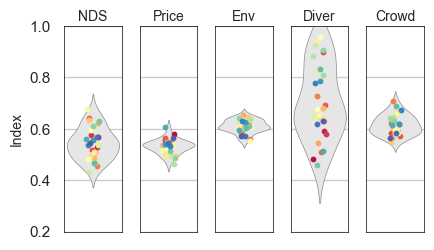

'output_figure_Yamanote.svg'

In [32]:
n_colors = len(df)  # Number of unique stations
colors = sns.color_palette("Spectral", n_colors)

# Set the font to Arial
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['text.color'] = 'black'

# # Initialize a matplotlib subplot with 5 rows and 1 column
# fig, axes = plt.subplots(5, 1, figsize=(4, 10))  # size is in inches

# Determine common x-axis range
x_min = df.iloc[:, 1:].min().min()  # Minimum value across all columns
x_max = df.iloc[:, 1:].max().max()  # Maximum value across all columns

# Set the font to Arial
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['text.color'] = 'black'

# Define a lighter shade of gray using an RGB tuple with lower intensity
lighter_gray = (0.9, 0.9, 0.9)

# Initialize a matplotlib subplot with 1 row and 5 columns (transposed layout)
fig, axes = plt.subplots(1, 5, figsize=(4.5, 3))  # Adjusted the figsize for transposition

# x_min and x_max for demonstration, assuming they are given
x_min = 0.2
x_max = 1

# Iterate over the columns to create a violin plot for each attribute, rotated 90 degrees
for i, column in enumerate(df.columns[1:]):
    # Draw the violin plot with the lighter gray color
    sns.violinplot(ax=axes[i], y=df[column], inner=None, color=lighter_gray, cut=2, linewidth=0.5, orient='h')
    
    # Manually plot each point with a randomized x-coordinate for spreading
    for j, value in enumerate(df[column]):
        x_offset = np.random.uniform(-0.1, 0.1)  # Adjust the range as needed
        axes[i].scatter(x_offset, value, color=colors[j], s=10, zorder=2)
    
    # Set labels and title
    if i == 0:  # Only the leftmost subplot has y-axis label and limits
        axes[i].set_ylabel('Index', fontsize=10)
        axes[i].set_ylim(x_min, x_max)
    else:
        axes[i].set_ylabel('')
        axes[i].set_ylim(x_min, x_max)
        axes[i].set_yticklabels([])  # Hide y-axis tick labels
    
    axes[i].set_xlabel(column, fontsize=10, rotation=0)
    axes[i].xaxis.set_label_position('top')  # Move x-axis labels to the top

    # Set the color and linewidth of the outer frame
    for spine in axes[i].spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.5)  # Set the linewidth here (adjust as needed)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Rotate the figure to match the user's request of rotating it 90 degrees counter-clockwise
fig.autofmt_xdate(rotation=45)  # Adjust text orientation if needed

# # Save the figure with DPI set to 500
# plt.savefig("output_figure.png", dpi=500, bbox_inches='tight')
# Save the figure as an SVG file
output_svg_file = 'output_figure_Yamanote.svg'
plt.savefig(output_svg_file, format='svg', bbox_inches='tight')

# # Show the plot
plt.show()

# Return the path to the saved SVG file
output_svg_file



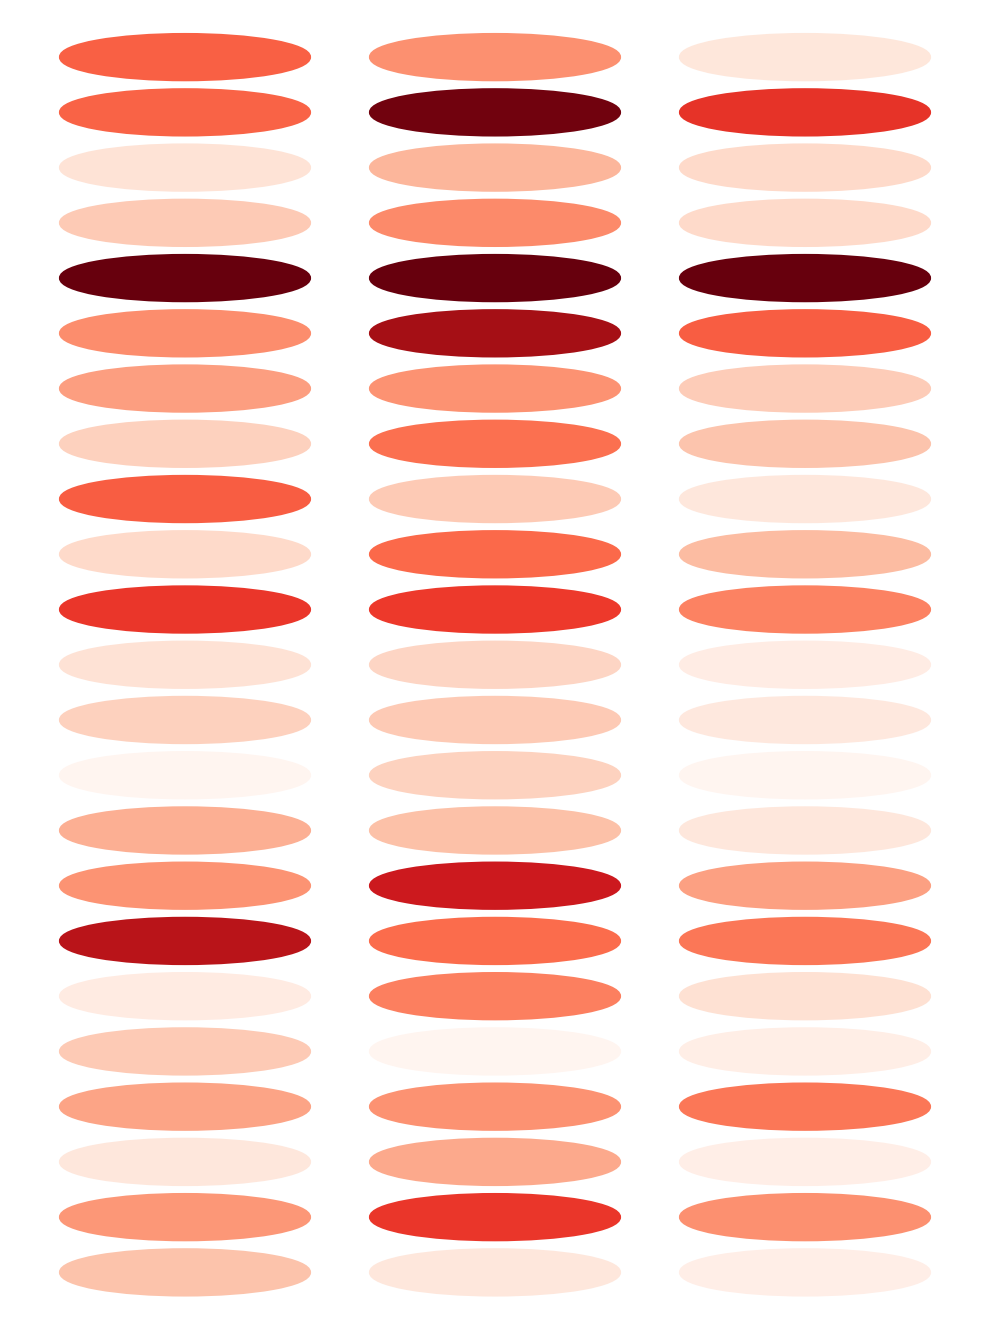

In [33]:
data = {
    "区域": ["世田谷区", "中央区", "中野区", "北区", "千代田区", "台東区", "品川区", "墨田区", "大田区", 
             "文京区", "新宿区", "杉並区", "板橋区", "江戸川区", "江東区", "渋谷区", "港区", 
             "目黒区", "練馬区", "荒川区", "葛飾区", "豊島区", "足立区"],
    "Total": [35.07416743, 34.62658192, 13.87278237, 18.43238475, 59.26950655, 28.24064335, 25.48583156, 
              17.23279714, 35.48291581, 15.67916338, 41.02315425, 14.17304955, 17.37524335, 8.240874564, 
              22.88186883, 27.31442533, 49.38020952, 11.33401211, 18.42519397, 24.68988566, 12.48073338, 
              26.59065877, 19.65718921],
    "Sta ave": [0.797140169, 0.935853565, 0.770710132, 0.801408033, 0.940785818, 0.910988495, 0.796432236, 
                0.820609387, 0.754955655, 0.825219125, 0.854649047, 0.745949976, 0.755445363, 0.749170415, 
                0.762728961, 0.881110494, 0.823003492, 0.809572293, 0.708661306, 0.796447924, 0.780045836, 
                0.857763186, 0.728044045],
    "Area ave": [0.604206157, 3.391437994, 0.889851339, 0.894341812, 5.083148074, 2.793337621, 1.115842012, 
                 1.251474011, 0.58331277, 1.388765578, 2.251545239, 0.416120069, 0.539268881, 0.165147787, 
                 0.56976765, 1.807705184, 2.424163452, 0.772597962, 0.383219508, 2.430106856, 0.358641764, 
                 2.043863088, 0.369149093]
}

df = pd.DataFrame(data)
df.set_index('区域', inplace=True)
normalized_df = (df - df.min()) / (df.max() - df.min())

# Create a grid with the same shape as the data to place the circle
x = np.arange(len(df.columns)) 
y = np.arange(len(df.index))
x, y = np.meshgrid(x, y)

fig, ax = plt.subplots(figsize=(4, 5.5), dpi=300)

for i in range(len(df.index)):
    for j in range(len(df.columns)):
        color = plt.cm.Reds(normalized_df.iloc[i, j])  # coolwarm

        circle = plt.Circle((j + 0.5, len(df.index) - i - 0.5), 0.4, color=color)  
        ax.add_artist(circle)

ax.set_xlim(0, len(df.columns))
ax.set_ylim(0, len(df.index))

ax.set_xticks(np.arange(len(df.columns)))
ax.set_yticks(np.arange(len(df.index)))
ax.set_xticklabels(df.columns)
ax.set_yticklabels(df.index)

ax.axis('off')
fig.savefig('heatmap.svg', format='svg', bbox_inches='tight')


In [34]:
# Load the DataFrames from the specified Excel files
df1_path = 'merged_with_carbon.xlsx'
df2_path = 'Categorized_restaurants_0320.xlsx'

# Reading the dataframes
df1 = pd.read_excel(df1_path)
df2 = pd.read_excel(df2_path)
df2_with_name = pd.merge(df2, df1[['id', 'NAME']], on='id', how='left')

# Performing a left merge of df2 with the 'NAME' column from df1 using 'id' as the key
# This will keep all rows from df2 and add information from df1 where the IDs match
merged_df = df2.merge(df1[['id', 'NAME']], on='id', how='left')


In [35]:
df2_with_name = pd.merge(df2, df1[['id', 'NAME']], on='id', how='left')

In [36]:
df2_with_name
# Extract unique elements from the column
unique_elements = df2_with_name['primaryTypeDisplayName'].unique()

array(['Bar', 'Seafood restaurant', 'Japanese restaurant', 'Restaurant',
       'Cafe', 'Ramen restaurant', 'Italian restaurant', nan,
       'Chinese restaurant', 'Korean restaurant', 'Sports complex',
       'Spanish restaurant', 'Coffee shop', 'Sandwich shop', 'Bakery',
       'Hamburger restaurant', 'Takeout restaurant', 'Liquor store',
       'Indian restaurant', 'Meal delivery', 'Sushi restaurant',
       'Fast food restaurant', 'Pharmacy', 'Store', 'French restaurant',
       'School', 'Real estate agency', 'Pizza restaurant',
       'Barbecue restaurant', 'Hair salon', 'Breakfast restaurant',
       'Vietnamese restaurant', 'Event venue', 'Steak house',
       'Thai restaurant', 'Ice cream shop', 'Mexican restaurant',
       'American restaurant', 'Supermarket', 'Vegetarian restaurant',
       'Hotel', 'Vegan restaurant', 'Mediterranean restaurant',
       'Amusement center', 'Middle Eastern restaurant',
       'Turkish restaurant', 'Brazilian restaurant', 'Wholesaler',
       

In [37]:
# Remove any duplicates based on 'id' column to ensure each id is unique in the result
unique_df2_with_name = df2_with_name.drop_duplicates(subset=['id'], keep='first')

In [38]:
# Save the merged and deduplicated DataFrame to a new Excel file, ensuring not to include the index
output_path = '240524_merged_and_unique_df.xlsx'
unique_df2_with_name.to_excel(output_path, index=False)

In [39]:
counts = unique_df2_with_name.groupby(['NAME', 'FIES_category']).size()
counts_df = counts.reset_index(name='count')
counts_df.to_excel('counts_per_district.xlsx', index=False)

In [ ]:
# Define a font dictionary with Arial font and black color
font_dict = {'fontname': 'Arial', 'color': 'black'}

district_data = pd.DataFrame({
    'District': [
        "Chiyoda Ward", "Chuo-ku", "Minato-ku", "Shinjuku ward", "Bunkyo Ward", 
        "Taito", "Sumida Ward", "Koto Ward", "Shinagawa Ward", "Meguro", 
        "Ota-ku", "Setagaya", "Shibuya Ward", "Nakano", " Suginami", 
        "Toshima ward", "Kita Ward", "Arakawa", "Itabashi Ward", "Nerima Ward", 
        "Adachi Ward", "Katsushika", "Edogawa Ward"
    ],
    'Pop': [
        68439, 175798, 267122, 354182, 245611,
        220691, 280877, 536806, 423324, 285675,
        745798, 939820, 243855, 347331, 589396,
        306259, 359497, 220413, 586321, 753537,
        696335, 456030, 691407
    ],
    'Area': [
        11.66, 10.21, 20.37, 18.22, 11.29,
        10.11, 13.77, 40.16, 22.84, 14.67,
        60.83, 58.05, 15.11, 15.59, 34.06,
        13.01, 20.61, 10.16, 32.22, 48.08,
        53.25, 34.8, 49.9
    ],
    'Pop_den': [
        5870, 17218, 13114, 19439, 21755,
        21829, 20398, 13367, 18534, 19473,
        12260, 16190, 16139, 22279, 17305,
        23540, 17443, 21694, 18197, 15673,
        13077, 13104, 13856
    ],
    'N_Station': [
        27,22,34,30,14,
        15,13,28,26,9,
        40,37,19,13,19,
        23,19,20,21,18,
        23,13,11
    ],
    'Lines': [
        21, 10,16,14,12,
        10,8,10,11,9,
        9,6,11,7,4,
        10,8,5,6,8,
        8,7,5
    ],
    'N_Res': [
        6868, 8799, 11955, 10180, 2543, 5729, 3035, 3864, 4029,
        3343, 4792, 6555, 8800, 2667, 4309, 5162, 2546, 1564,
        2874, 2878, 3618, 2781, 3176]
})

# Melt the DataFrame to a long format suitable for sns.boxplot
melted_data = pd.melt(district_data, id_vars='District', value_vars=['Pop', 'Area', 'Pop_den', 'N_Station','Lines','N_Res'],
                      var_name='Metric', value_name='Value')

# Define color palette
palette = sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=True)

# Normalize the values for each metric for color intensity
melted_data['Normalized'] = melted_data.groupby('Metric')['Value'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

# Create subplots stacked vertically
fig, axes = plt.subplots(6, 1, figsize=(3, 2.25), sharex=False)  # 3 subplots stacked vertically

for i, metric in enumerate(['Pop', 'Area', 'Pop_den', 'N_Station','Lines','N_Res']):
    # Create a horizontal boxplot for the current metric with increasing values from left to right
#     sns.boxplot(y='Metric', x='Value', data=melted_data[melted_data['Metric'] == metric],
#                 palette=palette(melted_data[melted_data['Metric'] == metric]['Normalized']),
#                 ax=axes[i], width=0.6)  # Adjust the width parameter to control bar spacing
    # Create a horizontal boxplot for the current metric with increasing values from left to right
    sns.boxplot(y='Metric', x='Value', data=melted_data[melted_data['Metric'] == metric],
                color='lightblue',  # Set the color to light blue
                ax=axes[i], width=0.6)  # Adjust the width parameter to control bar spacing
    
    # Add a horizontal line to mark the data location of Meguro
    meguro_value = melted_data[(melted_data['Metric'] == metric) & (melted_data['District'] == "Setagaya")]['Value'].values[0]
    axes[i].axvline(x=meguro_value, color='red', linestyle='--', linewidth=3, label='Setagaya', alpha=0.5)
    
    # Customize subplot labels and titles
    axes[i].set_xlabel('', **font_dict)  # Remove x-axis label
    axes[i].set_ylabel('', **font_dict)  # Remove y-axis label
    axes[i].set_xticks([])  # Remove x-axis ticks
#     axes[i].set_title(f'{metric}', **font_dict)  # Set subplot title
    axes[i].set_yticklabels([])  # Remove y-axis labels

    # Remove x-axis ticks and labels
    axes[i].tick_params(axis='x', which='both', bottom=False)
    
    # Set the spines (borders) of the plot to be transparent
    for spine in axes[i].spines.values():
        spine.set_alpha(0)

# Adjust layout
plt.tight_layout()

# Save the plots as PNG images
plt.savefig('Setagaya_box_plots_vertical_0524.svg', dpi=300)

# Show the plot
plt.show()


In [5]:
file_path = 'Revised_SDOI_crowd12.xlsx'
df = pd.read_excel(file_path,sheet_name='Original Data')
avg_values = df.groupby('NAME')['Average_Nutrition_Score', 'Average_Carbon_Score_Normalized4', 'Composite_Diversity_Index_Root5', 'Average_Price_Score', 'Crowdness_Normalized_Root12'].mean()
sum_values = df.groupby('NAME')['Average_Nutrition_Score', 'Average_Carbon_Score_Normalized4', 'Composite_Diversity_Index_Root5', 'Average_Price_Score', 'Crowdness_Normalized_Root12'].sum()

output_path = 'District_Statistics.xlsx'
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    avg_values.to_excel(writer, sheet_name='Average_Values')
    sum_values.to_excel(writer, sheet_name='Sum_Values')

/var/folders/d7/p46qc1857_x7221pjnvz6rz80000gn/T/ipykernel_5965/2409920063.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  avg_values = df.groupby('NAME')['Average_Nutrition_Score', 'Average_Carbon_Score_Normalized4', 'Composite_Diversity_Index_Root5', 'Average_Price_Score', 'Crowdness_Normalized_Root12'].mean()
/var/folders/d7/p46qc1857_x7221pjnvz6rz80000gn/T/ipykernel_5965/2409920063.py:9: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sum_values = df.groupby('NAME')['Average_Nutrition_Score', 'Average_Carbon_Score_Normalized4', 'Composite_Diversity_Index_Root5', 'Average_Price_Score', 'Crowdness_Normalized_Root12'].sum()


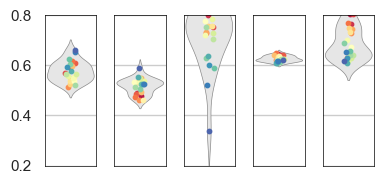

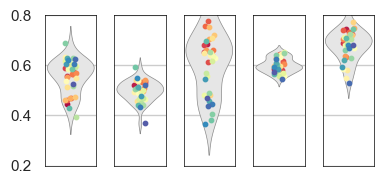

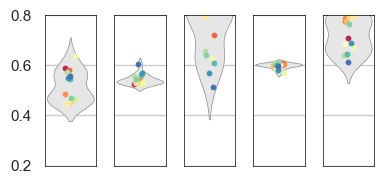

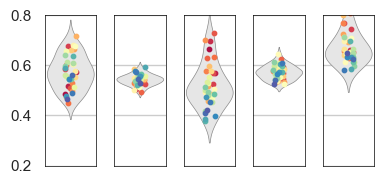

In [11]:
file_path = 'District_Statistics.xlsx'
df = pd.read_excel(file_path)

# Set the style of the background to be a lighter color
sns.set(style="whitegrid")

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['text.color'] = 'black'
lighter_gray = (0.9, 0.9, 0.9)

for selected_district in ['千代田区', '港区', '台東区', '世田谷区']:
    district_data = df[df['District'] == selected_district]
    fig, axes = plt.subplots(1, 5, figsize=(4, 2)) 

    # Create a color palette for each data point in the selected district
    n_colors_district = len(district_data)
    colors_district = sns.color_palette("Spectral", n_colors_district)

    for i, metric in enumerate(['NDS', 'price', 'Diver', 'env', 'Crowd']):
        sns.violinplot(ax=axes[i], y=district_data[metric], inner=None, color=lighter_gray, cut=2, linewidth=0.5)
        for j, value in enumerate(district_data[metric].values):
            x_offset = np.random.uniform(-0.1, 0.1) 
            axes[i].scatter(x_offset, value, color=colors_district[j], s=10, zorder=2)
        axes[i].set_ylabel('')
        axes[i].set_xlabel('', fontsize=10)
        axes[i].set_ylim(0.2, 0.8)

        for spine in axes[i].spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(0.5)

        if i != 0:
            axes[i].set_yticklabels([])

    plt.tight_layout()

    output_svg_file = f'{selected_district}_violin_vertical.svg'
    plt.savefig(output_svg_file, dpi=500, format='svg', bbox_inches='tight')
    plt.show()


In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Your provided data
district_data = pd.DataFrame({
    'District': [
        "Chiyoda Ward", "Chuo-ku", "Minato-ku", "Shinjuku ward", "Bunkyo Ward", 
        "Taito", "Sumida Ward", "Koto Ward", "Shinagawa Ward", "Meguro", 
        "Ota-ku", "Setagaya", "Shibuya Ward", "Nakano", " Suginami", 
        "Toshima ward", "Kita Ward", "Arakawa", "Itabashi Ward", "Nerima Ward", 
        "Adachi Ward", "Katsushika", "Edogawa Ward"
    ],
    'NDS': [14.34837719, 10.55607222, 20.41623058, 15.70245216, 7.722356039, 7.123787443, 8.330040902, 14.68104893, 14.18727305, 5.772945272, 22.59385785, 20.51827745, 9.84573836, 6.914218151, 9.552339291, 12.37635383, 9.268226546, 12.8117484, 11.7567952, 11.19733329, 12.40073707, 6.847895457, 6.20759163],
    'env': [15.47565585, 11.46254674, 21.79309904, 17.67204285, 7.641777129, 8.266630552, 8.129482202, 13.80465351, 15.4770187, 5.632302958, 21.19550862, 20.34170637, 9.668016519, 7.323120811, 10.31357518, 12.88917545, 9.201831767, 12.91857866, 12.95226894, 11.6950383, 12.45378435, 6.894063125, 6.416051718],
    'Diver': [16.35194574, 12.49693258, 20.97250012, 17.30097965, 6.980264457, 8.910550199, 7.038565433, 10.61009242, 12.92215311, 5.098802955, 16.59027582, 17.67969193, 9.789293935, 6.38675047, 8.286555545, 11.15718372, 7.672080332, 10.41999267, 9.886320117, 8.95424757, 8.824680538, 5.614542237, 4.847758926],
    'price': [13.03418283, 9.75439117, 18.44653336, 16.09520066, 6.956177637, 7.63729359, 7.947078852, 13.39086306, 14.51109138, 5.25813969, 19.99762253, 19.5279205, 8.873873677, 7.410732596, 10.11885478, 12.32308393, 9.265847821, 13.23497172, 12.74261148, 11.33200017, 11.97610611, 6.907432731, 6.27891145],
    'Crowd': [12.81955074, 10.14905992, 18.13203053, 14.70689503, 5.849515645, 7.583613733, 6.367824235, 9.627737172, 11.80918666, 5.103211638, 16.05850348, 16.95867963, 8.540979864, 5.69241467, 7.207484716, 11.99260485, 7.519748444, 12.66595807, 8.981545592, 7.368475349, 8.147119297, 5.084302408, 4.070965237],
    'SDI': [0.84, 0.78, 0.71, 0.76, 0.75, 0.79, 0.76, 0.72, 0.69, 0.70, 0.69, 0.71, 0.77, 0.72, 0.70, 0.77, 0.75, 0.72, 0.71, 0.70, 0.72, 0.72, 0.74],
    'Pop': [
        68439, 175798, 267122, 354182, 245611,
        220691, 280877, 536806, 423324, 285675,
        745798, 939820, 243855, 347331, 589396,
        306259, 359497, 220413, 586321, 753537,
        696335, 456030, 691407
    ],
    'Area': [
        11.66, 10.21, 20.37, 18.22, 11.29,
        10.11, 13.77, 40.16, 22.84, 14.67,
        60.83, 58.05, 15.11, 15.59, 34.06,
        13.01, 20.61, 10.16, 32.22, 48.08,
        53.25, 34.8, 49.9
    ],
    'Pop_den': [
        5870, 17218, 13114, 19439, 21755,
        21829, 20398, 13367, 18534, 19473,
        12260, 16190, 16139, 22279, 17305,
        23540, 17443, 21694, 18197, 15673,
        13077, 13104, 13856
    ],
    'N_Station': [
        27,22,34,30,14,
        15,13,28,26,9,
        40,37,19,13,19,
        23,19,20,21,18,
        23,13,11
    ],
    'Lines': [
        21, 10,16,14,12,
        10,8,10,11,9,
        9,6,11,7,4,
        10,8,5,6,8,
        8,7,5
    ],
    'N_Res': [
        6868, 8799, 11955, 10180, 2543, 5729, 3035, 3864, 4029,
        3343, 4792, 6555, 8800, 2667, 4309, 5162, 2546, 1564,
        2874, 2878, 3618, 2781, 3176]

})

# Selecting features for clustering
features = ['Pop_den','Area','N_Res','Lines','price']
X = district_data[features]

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying k-means clustering
kmeans = KMeans(n_clusters=4, random_state=42)
district_data['Cluster'] = kmeans.fit_predict(X_scaled)

print(district_data[['District', 'Cluster']])


In [ ]:
# Get the centroids of the clusters
centroids = kmeans.cluster_centers_

# Inverse transform the scaled centroids to get them back into the original scale
original_centroids = scaler.inverse_transform(centroids)

# Create a DataFrame for the centroids for easier interpretation
centroids_df = pd.DataFrame(original_centroids, columns=features)

# Now we can print out the centroids to understand the average characteristics of each cluster
print(centroids_df)

# If you wish to name the clusters based on their characteristics, you can assign names
# based on the most distinguishing features of each cluster.
# For example, if one cluster has significantly higher SDI scores, you might name it "High SDI Cluster".

# Naming clusters can be subjective, but one approach is to look for the highest values in each centroid
for index, row in centroids_df.iterrows():
    print(f"Cluster {index} characteristics:")
    # Get the most prominent feature(s) by selecting the top values
    top_features = row.nlargest(2).index.tolist()
    print(f"Top features: {top_features}")
